In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [87]:
def symbol_to_path(symbol, base_dir="data"):
    return  base_dir + "/{}.csv".format(str(symbol))

def get_data(symbols, dates):
    '''
    Получает цену акций (Adj Close) для данного symbol из CSV файла
    '''
    # Создаем пустой датафрейм и удостоверимся, что SPY будет на первом месте
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:
        symbols.insert(0, 'SPY')
    
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date', usecols=['Date', 'Adj Close'], parse_dates=True, na_values=['nan']) 
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp, how='inner')
    return df

def plot_df(df, title='Цены на акции'):
    '''Рисует графики цен всего DataFrame'''
    df.plot(title=title, fontsize=11)
    plt.xlabel('Дата')
    plt.ylabel('Цены')
    plt.show()

def plot_selected(df, columns, start_index, end_index):
    '''Рисует графики цен указанных столбцов'''
    df.loc[start_index:end_index, columns].plot(title='Цены на акции', fontsize=11)
    plt.xlabel('Дата')
    plt.ylabel('Цены')
    plt.show()    
    
def normalize_data(df):
    '''Нормализует весь датафрэйм для отображения изменения цен.'''
    df = df / df.iloc[0, :]
    return df

def get_rolling_mean(df, window):
    return df.rolling(window).mean()

def get_rolling_std(df, window):
    return df.rolling(window).std()

def get_Boolinger_bonds(rm, rstd):
    upper_bond = rm + 2 * rstd
    lower_bond = rm - 2 * rstd
    return lower_bond, upper_bond

def get_daily_return(df):
    daily_returns = df.copy()
    daily_returns[1:] = (df / df.shift(1)) - 1
    daily_returns.iloc[0, :] = 0
    return daily_returns

def get_hist(df, bins=20):
    df.hist(bins=bins)
    mean = df.mean()
    std = df.std()
    
    # Чертим вертикальную белую черту, отображающую среднее значение
    # Чертим вертикальные красные линии, отображающие отклонения
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(-std, color='r', linestyle='dashed', linewidth=2)
    plt.show()
    
def get_double_hist(df, bins=20, alpha=0.7):
    '''Создаем две диаграммы для двух бумаг'''
    for symbol in df.keys():
        df[symbol].hist(bins=bins, label=symbol, alpha=alpha)
    plt.legend()
    

In [90]:
def test_run():
    dates = pd.date_range('2009-01-01', '2012-12-31')
    symbols = ['SPY', 'XOM']
    df = get_data(symbols, dates)
    plot_df(df)
    
    # Получаем ежедневные доходности и строим гистограмму
    daily_returns = get_daily_return(df)
    plot_df(daily_returns, title='Daily Returns')
    
    # Построим гистограммы доходностей
    get_double_hist(daily_returns)
    
    # Считаем куртозис (отличие от нормального распределения)
    print(daily_returns.kurtosis())
    
    # Больше ноля -> тяжелые хвосты

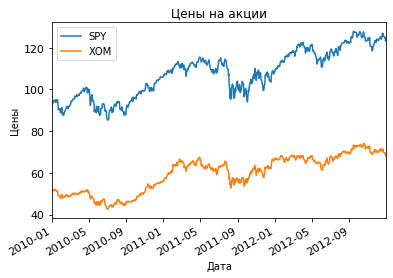

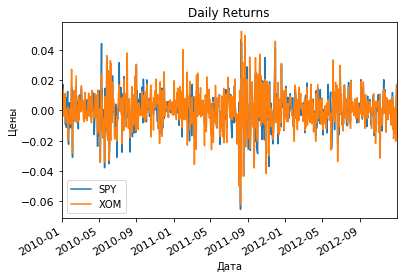

SPY    3.416317
XOM    2.489898
dtype: float64


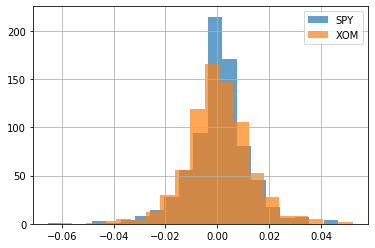

In [91]:
test_run()

### Scatterplots
Хотим построить точечную диаграмму of $\textbf{daily returns}$. Если зафитить на точки прямую - получим регрессию. Угол наклона регрессии - $\beta$. Бета показывает как сильно бумага реагирует на изменение рынка. 

Допустим если $\beta =  2$, то это означает, что в среднем, если рынок пойдет в гору на $1$%, то бумага поднимется на $2$%.
Если провести в нуле вертикальную линию, то пересечение с регрессией даст нам альфу. 

$\alpha$ - показатель того, как в среднем доходность бумаги соотносится с рыночной доходностью. Если $\alpha > 0  \Rightarrow$ бумага идет лучше рынка. Если $\alpha < 0$, то доходность бумаги меньше рыночной доходности.


Наклон регресии - $\textbf{НЕ}$ корреляция!!
Корреляция показывает как сильно точки прилегают к прямой.

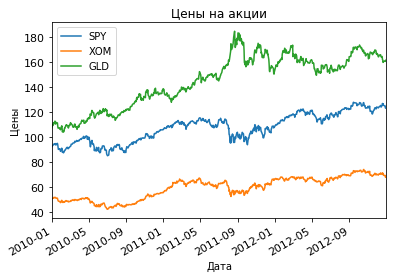

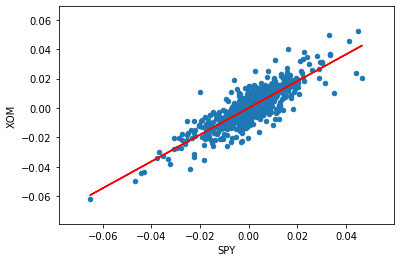

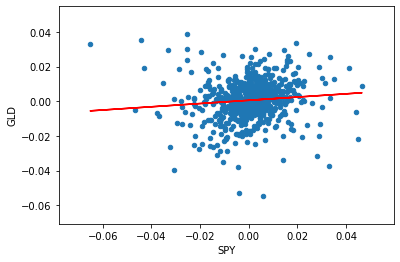

beta_XOM: 0.9125788311614936
alpha_XOM: 6.1009470918744346e-05
beta_GLD: 0.09345849561948846
alpha_GLD: 0.0005627087224035216

Kорреляция:
           SPY       XOM       GLD
SPY  1.000000  0.843273  0.097794
XOM  0.843273  1.000000  0.121566
GLD  0.097794  0.121566  1.000000


In [116]:
def test_run():
    # Получаем данные
    dates = pd.date_range('2009-01-01', '2012-12-31')
    symbols = ['SPY', 'XOM', 'GLD']
    df = get_data(symbols, dates)
    daily_returns = get_daily_return(df)
    plot_df(df)
    
    # Построим Scatter Plot для XOM
    daily_returns.plot(kind='scatter', x='SPY', y='XOM')
    
     # Зафитим полином первой степени в данные скаттерплоты...
    # ...параметр 1 показывает степень полинома.
    beta_XOM, alpha_XOM = np.polyfit(daily_returns['SPY'], daily_returns['XOM'], 1)
    plt.plot(daily_returns['SPY'], beta_XOM * daily_returns['SPY'] + alpha_XOM, '-', color='r')
    plt.show();
    
    # Построим Scatter Plot для GLD
    daily_returns.plot(kind='scatter', x='SPY', y='GLD')
    
    # Регрессия
    beta_GLD, alpha_GLD = np.polyfit(daily_returns['SPY'], daily_returns['GLD'], 1)
    plt.plot(daily_returns['SPY'], beta_GLD * daily_returns['SPY'] + alpha_GLD, '-', color='r')
    plt.show();
    
    
    print("beta_XOM:", beta_XOM)
    print("alpha_XOM:", alpha_XOM)
    print("beta_GLD:", beta_GLD)
    print("alpha_GLD:", alpha_GLD)
    print("\nKорреляция:\n", daily_returns.corr(method='pearson'))
    
test_run()

$\textbf{Выводы:}$

1. Поскольку $\beta_{XOM} > \beta_{GLD} \Rightarrow$ XOM больше реагирует на рыночные изменения, чем GLD.
2. Поскольку $\alpha_{XOM} < \alpha_{GLD} \Rightarrow$ GLD шел лучше, чем XOM относительно рынка.


